In [1]:
import qsample as qs
import qiskit
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

# Input = STIM

In [2]:
eft = qs.Circuit(noisy=True)
sz_123 = qs.Circuit(noisy=True)
meas7 = qs.Circuit(noisy=False)

eft.from_stim_circuit("""R 0 1 2 3 4 5 6 7
H 0 1 3
                        CNOT 0 4
                        CNOT 1 2
                        TICK
                        CNOT 3 5
                        TICK
                        CNOT 0 6
                        TICK
                        CNOT 3 4
                        TICK
                        CNOT 1 5
                        TICK
                        CNOT 0 2
                        TICK
                        CNOT 5 6
                        TICK
                        CNOT 4 7
                        TICK
                        CNOT 2 7
                        TICK
                        CNOT 5 7
                        M 7""")

sz_123.from_stim_circuit("""R 8
CNOT 0 8
                        TICK
                        CNOT 1 8
                        TICK
                        CNOT 3 8
                        TICK
                        CNOT 6 8
                            M 8""")

meas7.from_stim_circuit("""M 0 1 2 3 4 5 6""")





k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []
def logErr(out):
    global fails
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit(noisy=True).from_stim_circuit("""X 6"""))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [3]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
stim_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
stim_sam.run(2000)
end = time.time()
stim_time = end-begin

v2 = stim_sam.stats()[0]
w2 = stim_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

# Input = qsample

In [4]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)





k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []

def logErr(out):
    global fails
    
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [5]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

# Input = QASM

In [6]:
eft = qs.Circuit().from_qasm_circuit("""OPENQASM 2.0;
include "qelib1.inc";

qreg q[8];
creg c[1];

h q[0];
h q[1];
h q[3];

cx q[0], q[4];
cx q[1], q[2];
cx q[3], q[5];
cx q[0], q[6];
cx q[3], q[4];
cx q[1], q[5];
cx q[0], q[2];
cx q[5], q[6];
cx q[4], q[7];
cx q[2], q[7];
cx q[5], q[7];

measure q[7] -> c[0];""")

sz_123 = qs.Circuit().from_qasm_circuit("""OPENQASM 2.0;
include "qelib1.inc";

qreg q[9];
creg c[1];

// Initialize qubit 8 (default is |0⟩)

// Apply CNOT gates with control qubits 0,1,3,6 and target qubit 8
cx q[0], q[8];
cx q[1], q[8];
cx q[3], q[8];
cx q[6], q[8];

// Measure qubit 8 into classical bit 0
measure q[8] -> c[0];""")

meas7 = qs.Circuit(noisy=False).from_qasm_circuit("""OPENQASM 2.0;
include "qelib1.inc";

qreg q[7];
creg c[7];

measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
measure q[6] -> c[6];""")





k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []

def logErr(out):
    global fails
    
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit().from_qasm_circuit("""OPENQASM 2.0;
include "qelib1.inc";

qreg q[8];
x q[6];"""))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [7]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
stim_time = end-begin

v3 = ss_sam.stats()[0]
w3 = ss_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

# Input = Qiskit

In [8]:
q = qiskit.QuantumRegister(8)
c = qiskit.ClassicalRegister(1)
eft = qiskit.QuantumCircuit(q, c)

eft.h(q[0])
eft.h(q[1])
eft.h(q[3])


eft.cx(q[0], q[4])
eft.cx(q[1], q[2])
eft.cx(q[3], q[5])
eft.cx(q[0], q[6])
eft.cx(q[3], q[4])
eft.cx(q[1], q[5])
eft.cx(q[0], q[2])
eft.cx(q[5], q[6])
eft.cx(q[4], q[7])
eft.cx(q[2], q[7])
eft.cx(q[5], q[7])

eft.measure(q[7], c[0])

eft = qs.Circuit().from_qiskit_circuit(eft)

# ==========

q = qiskit.QuantumRegister(7)
c = qiskit.ClassicalRegister(7)
meas7 = qiskit.QuantumCircuit(q, c)

meas7.measure(q[0], c[0])
meas7.measure(q[1], c[1])
meas7.measure(q[2], c[2])
meas7.measure(q[3], c[3])
meas7.measure(q[4], c[4])
meas7.measure(q[5], c[5])
meas7.measure(q[6], c[6])


meas7 = qs.Circuit().from_qiskit_circuit(meas7)

# =========
q = qiskit.QuantumRegister(9)
c = qiskit.ClassicalRegister(1)
sz_123 = qiskit.QuantumCircuit(q, c)

sz_123.cx(q[0], q[8])
sz_123.cx(q[1], q[8])
sz_123.cx(q[3], q[8])
sz_123.cx(q[6], q[8])
sz_123.measure(q[8], c[0])


sz_123 = qs.Circuit().from_qiskit_circuit(sz_123)

# ===========






k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []

def logErr(out):
    global fails
    
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit().from_qasm_circuit("""OPENQASM 2.0;
include "qelib1.inc";

qreg q[8];
x q[6];"""))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [9]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
stim_time = end-begin

v4 = ss_sam.stats()[0]
w4 = ss_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

1.8705940246582031
0.95461106300354


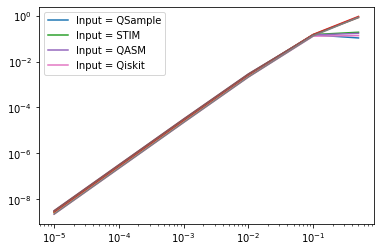

In [10]:
plt.plot(q, v1, label = "Input = QSample")
plt.plot(q, w1)
plt.plot(q, v2, label = "Input = STIM")
plt.plot(q, w2)
plt.plot(q, v3, label = "Input = QASM")
plt.plot(q, w3)
plt.plot(q, v4, label = "Input = Qiskit")
plt.plot(q, w4)

plt.xscale('log')
plt.yscale('log')
plt.legend()

print(qsample_time)
print(stim_time)

In [11]:
qsample_times = []
stim_times = []

samples = [100, 300, 1000, 3000, 10000, 50000]

for s in samples:
    begin = time.time()
    stim_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
    stim_sam.run(s)
    end = time.time()
    qsample_times.append(end-begin)

    begin = time.time()
    ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
    ss_sam.run(s)
    end = time.time()
    stim_times.append(end-begin)

plt.plot(samples, stim_sam.stats()[0])
plt.plot(samples, stim_sam.stats()[2])
plt.plot(samples, ss_sam.stats()[0])
plt.plot(samples, ss_sam.stats()[2])
plt.xscale('log')
plt.yscale('log')

p=('1.00e-01',):   0%|          | 0/100 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/100 [00:00<?, ?it/s]

p=('1.00e-01',):   0%|          | 0/300 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/300 [00:00<?, ?it/s]

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/1000 [00:00<?, ?it/s]

p=('1.00e-01',):   0%|          | 0/3000 [00:00<?, ?it/s]

p=('1.00e-02',):   0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Average ratio of stim time/stabilizer time: 0.45


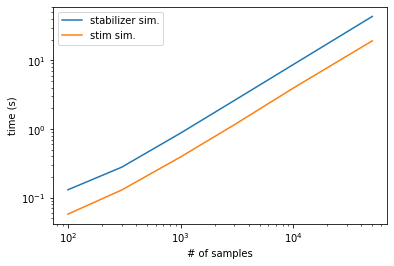

In [27]:
plt.plot(samples, qsample_times, label = 'stabilizer sim.')
plt.plot(samples, stim_times, label = 'stim sim.')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time (s)')
plt.xlabel('# of samples')

print('Average ratio of stim time/stabilizer time: {:.2f}'.format(np.average(np.array(stim_times)/np.array(qsample_times))))